In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import json
import numpy as np
import pandas as pd
import pickle
import math

import pandas as pd

import matplotlib.pyplot as plt

from tqdm.auto import tqdm, trange

from sklearn.metrics import  classification_report, confusion_matrix


In [3]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

FOLDERNAME = 'Project_data/data'

%cd drive/My\ Drive
%cp -r $FOLDERNAME ../../
%cd ../../
%cd data


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive
/content
/content/data


In [4]:
dataset = 'davis'

filename = dataset + '/ligands_can.txt'

with open(filename) as f:
  ligands = json.load(f)


filename =  dataset + '/proteins.txt'

with open(filename) as f:
  proteins = json.load(f)

len(ligands), len(proteins)

(68, 442)

In [5]:
if dataset == 'davis':
  max_length_prot = 1200
  max_length_lig = 85
else:
  max_length_prot = 1000
  max_length_lig = 100


In [6]:
CHARPROTSET = { "A": 1, "C": 2, "B": 3, "E": 4, "D": 5, "G": 6, 
				"F": 7, "I": 8, "H": 9, "K": 10, "M": 11, "L": 12, 
				"O": 13, "N": 14, "Q": 15, "P": 16, "S": 17, "R": 18, 
				"U": 19, "T": 20, "W": 21, 
				"V": 22, "Y": 23, "X": 24, 
				"Z": 25 }

CHARCANSMISET = { "#": 1, "%": 2, ")": 3, "(": 4, "+": 5, "-": 6, 
			 ".": 7, "1": 8, "0": 9, "3": 10, "2": 11, "5": 12, 
			 "4": 13, "7": 14, "6": 15, "9": 16, "8": 17, "=": 18, 
			 "A": 19, "C": 20, "B": 21, "E": 22, "D": 23, "G": 24,
			 "F": 25, "I": 26, "H": 27, "K": 28, "M": 29, "L": 30, 
			 "O": 31, "N": 32, "P": 33, "S": 34, "R": 35, "U": 36, 
			 "T": 37, "W": 38, "V": 39, "Y": 40, "[": 41, "Z": 42, 
			 "]": 43, "_": 44, "a": 45, "c": 46, "b": 47, "e": 48, 
			 "d": 49, "g": 50, "f": 51, "i": 52, "h": 53, "m": 54, 
			 "l": 55, "o": 56, "n": 57, "s": 58, "r": 59, "u": 60,
			 "t": 61, "y": 62}

In [7]:
def encode_data(data, max_length, mapping):
  res = np.zeros((len(data), max_length))
  
  for i, d in enumerate(data.keys()):
    print(d)
    for w in range(min(max_length, len(data[d]))):
      res[i][w] = mapping[data[d][w]]

  return res

def encode_one_hot(data, max_length, mapping):
  charlen = len(mapping)
  res = np.zeros((len(data), max_length, charlen))
  for i, d in enumerate(data.keys()):
    print(d)
    for w in range(min(max_length, len(data[d]))):
        res[i][w][mapping[data[d][w]]] = 1
  return res

In [8]:
protein_data = encode_data(proteins, max_length_prot, CHARPROTSET)
ligand_data = encode_data(ligands, max_length_lig, CHARCANSMISET)

AAK1
ABL1(E255K)
ABL1(F317I)
ABL1(F317I)p
ABL1(F317L)
ABL1(F317L)p
ABL1(H396P)
ABL1(H396P)p
ABL1(M351T)
ABL1(Q252H)
ABL1(Q252H)p
ABL1(T315I)
ABL1(T315I)p
ABL1(Y253F)
ABL1
ABL1p
ABL2
ACVR1
ACVR1B
ACVR2A
ACVR2B
ACVRL1
ADCK3
ADCK4
AKT1
AKT2
AKT3
ALK
AMPK-alpha1
AMPK-alpha2
ANKK1
ARK5
ASK1
ASK2
AURKA
AURKB
AURKC
AXL
BIKE
BLK
BMPR1A
BMPR1B
BMPR2
BMX
BRAF
BRAF(V600E)
BRK
BRSK1
BRSK2
BTK
CAMK1
CAMK1D
CAMK1G
CAMK2A
CAMK2B
CAMK2D
CAMK2G
CAMK4
CAMKK1
CAMKK2
CASK
CDC2L1
CDC2L2
CDC2L5
CDK11
CDK2
CDK3
CDK4-cyclinD1
CDK4-cyclinD3
CDK5
CDK7
CDK8
CDK9
CDKL1
CDKL2
CDKL3
CDKL5
CHEK1
CHEK2
CIT
CLK1
CLK2
CLK3
CLK4
CSF1R
CSK
CSNK1A1
CSNK1A1L
CSNK1D
CSNK1E
CSNK1G1
CSNK1G2
CSNK1G3
CSNK2A1
CSNK2A2
CTK
DAPK1
DAPK2
DAPK3
DCAMKL1
DCAMKL2
DCAMKL3
DDR1
DDR2
DLK
DMPK
DMPK2
DRAK1
DRAK2
DYRK1A
DYRK1B
DYRK2
EGFR
EGFR(E746A750del)
EGFR(G719C)
EGFR(G719S)
EGFR(L747E749del)
EGFR(L747S752del)
EGFR(L747T751del)
EGFR(L858R)
EGFR(L858RT790M)
EGFR(L861Q)
EGFR(S752I759del)
EGFR(T790M)
EIF2AK1
EPHA1
EPHA2
EPHA3
EPHA4
EPHA5
EPHA

In [9]:
Y_path = dataset + '/Y'
with open(Y_path, 'rb') as f:
  Y = pickle.load(f, encoding='latin1')

if dataset == 'davis':
  Y = -(np.log10(Y/(math.pow(10,9))))
label_row_inds, label_col_inds = np.where(np.isnan(Y)==False)

label_row_inds.shape, label_col_inds.shape

((30056,), (30056,))

In [10]:
test_indices = json.load(open(dataset + "/folds/test_fold_setting1.txt"))
train_indices = json.load(open(dataset + "/folds/train_fold_setting1.txt"))


test_drug_indices = label_row_inds[test_indices]
test_protein_indices = label_col_inds[test_indices]

train_indices = np.concatenate([train_indices[0], train_indices[1], train_indices[2], train_indices[3], train_indices[4]])



train_drug_indices = label_row_inds[train_indices]
train_protein_indices = label_col_inds[train_indices]

test_drug_indices.shape, train_drug_indices.shape

np.unique(label_row_inds, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]),
 array([442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442,
        442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442,
        442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442,
        442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442,
        442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442, 442,
        442, 442, 442]))

In [11]:
train_drug_X = ligand_data[train_drug_indices]
train_prot_X = protein_data[train_protein_indices]

train_Y = Y[train_drug_indices, train_protein_indices]

test_drug_X = ligand_data[test_drug_indices]
test_prot_X = protein_data[test_protein_indices]

test_Y = Y[test_drug_indices, test_protein_indices]

train_Y.shape, train_drug_X.shape, train_prot_X.shape, test_Y.shape, test_drug_X.shape, test_prot_X.shape

((25046,), (25046, 85), (25046, 1200), (5010,), (5010, 85), (5010, 1200))

In [12]:
from sklearn.utils import resample
concat_train = np.column_stack([train_drug_X, train_prot_X, train_Y])

threshold = 0

if dataset == 'kiba':
  threshold = 12.1
else:
  threshold = 7

pos = concat_train[concat_train[:, -1] > threshold]
neg = concat_train[concat_train[:, -1] <= threshold]

pos_up = resample(pos, replace = True, n_samples = len(neg))

augmented = np.concatenate([pos_up, neg], 0)
train_drug_X = augmented[:, : (max_length_lig)]
train_prot_X = augmented[:, (max_length_lig): (max_length_lig + max_length_prot)]
train_Y = augmented[:, -1]

In [13]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [14]:
class DTADataset(Dataset):
  def __init__(self, X_ligand, X_prot, y):
    self.X_ligand = torch.tensor(X_ligand)
    self.X_prot = torch.tensor(X_prot)
    self.y = torch.tensor(y)
  def __getitem__(self, index):
     if torch.is_tensor(index):
            index = index.tolist()
     return  self.X_ligand[index], self.X_prot[index], self.y[index]
  def __len__(self):
    return self.X_ligand.shape[0]


In [15]:
trainset = DTADataset(train_drug_X, train_prot_X, train_Y)
testset = DTADataset(test_drug_X, test_prot_X, test_Y)




BATCH_SIZE = 256

trainloader = DataLoader(dataset = trainset,
                          batch_size = BATCH_SIZE,
                          shuffle=True)


testloader = DataLoader(dataset = testset,
                          batch_size = BATCH_SIZE,
                          shuffle=True)

In [16]:
class DrugProtLSTM(nn.Module):
     def __init__(self, hidden_dim, charlen, embedding_dim):
        super().__init__()
        

        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(charlen, embedding_dim)

        self.LSTM = nn.LSTM(embedding_dim, hidden_dim, 1, batch_first = True)

        self.fc1 = nn.Linear(hidden_dim, 256)
        self.relu = nn.ReLU()

     def forward(self, x):
          x_e = self.embedding(x)

          lstm_out, h = self.LSTM(x_e)

          x = h[0][-1].view(-1, self.hidden_dim)

          x = self.fc1(x)
          x = self.relu(x)


          return x
        

In [17]:
class DrugModel(nn.Module):
   def __init__(self, charlen, embedding_dim, num_filters, druglen):
        super().__init__()
        self.embedding = nn.Embedding(charlen, embedding_dim)

        self.conv1 = nn.Conv1d(embedding_dim, num_filters, kernel_size=4)
        self.conv2 = nn.Conv1d(num_filters, num_filters * 2, kernel_size=6)
        self.conv3 = nn.Conv1d(num_filters * 2, num_filters * 3, kernel_size=8)

        """self.fc1 = nn.Linear(((signal_len - 15) // 3) * num_filters * 3, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, 1)"""

        self.maxpooling = nn.MaxPool1d(druglen - 15)

        self.relu = nn.ReLU()


   def forward(self, x):
      x_e = self.embedding(x)
      x = torch.transpose(x_e, 1, 2)

      x = self.conv1(x)
      x = self.relu(x)

      x = self.conv2(x)
      x = self.relu(x)

      x = self.conv3(x)
      x = self.relu(x)
      y = x

      x = self.maxpooling(x)

      """x = torch.flatten(x, 1)

      x = self.fc1(x)
      x = self.relu(x)
    
      x = F.dropout(x, p=0.1, training=self.training)

      x = self.fc2(x)
      x = self.relu(x)

      x = F.dropout(x, p = 0.1, training=self.training)

      x = self.fc3(x)
      x = self.relu(x)

      x = self.fc4(x)"""

      return x

In [18]:
class DrugProtModel(nn.Module):
   def __init__(self, charlen, embedding_dim, num_filters):
        super().__init__()
        self.embedding = nn.Embedding(charlen, embedding_dim)

        self.conv1 = nn.Conv1d(embedding_dim, num_filters, kernel_size=4)
        self.conv2 = nn.Conv1d(num_filters, num_filters * 2, kernel_size=6)
        self.conv3 = nn.Conv1d(num_filters * 2, num_filters * 3, kernel_size=8)

        """self.fc1 = nn.Linear(((signal_len - 15) // 3) * num_filters * 3, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, 1)"""

        self.maxpooling = nn.MaxPool1d(3)

        self.relu = nn.ReLU()


   def forward(self, x):
      x_e = self.embedding(x)
      x = torch.transpose(x_e, 1, 2)

      x = self.conv1(x)
      x = self.relu(x)

      x = self.conv2(x)
      x = self.relu(x)

      x = self.conv3(x)
      x = self.relu(x)

      x = self.maxpooling(x)

      """x = torch.flatten(x, 1)

      x = self.fc1(x)
      x = self.relu(x)
    
      x = F.dropout(x, p=0.1, training=self.training)

      x = self.fc2(x)
      x = self.relu(x)

      x = F.dropout(x, p = 0.1, training=self.training)

      x = self.fc3(x)
      x = self.relu(x)

      x = self.fc4(x)"""

      return x


In [19]:
class DTAModel(nn.Module):
     def __init__(self, druglen, protlen):
       super().__init__()
       self.drugmodel = DrugModel(62, 128, 32, druglen)
       #self.protmodel = DrugProtModel(25, 128, 32)
       self.lstm_model = DrugProtLSTM(256, 25, 128)
       self.fc1 = nn.Linear(96 * (((druglen - 15) // 3) + ((protlen - 15) // 3)), 1024)
       self.fc_lstm = nn.Linear(96 + 256, 1024)
       self.fc2 = nn.Linear(1024, 1024)
       self.fc3 = nn.Linear(1024, 512)
       self.fc4=  nn.Linear(512, 1)

       self.relu = nn.ReLU()
    

     def forward(self, drug, prot):
        drug_rep = self.drugmodel(drug)
        drug_rep = drug_rep.squeeze(2)
        #prot_rep = self.protmodel(prot)
        prot_rep = self.lstm_model(prot)

        x = torch.cat([drug_rep, prot_rep], 1)

        x = torch.flatten(x, 1)

        #x = self.fc1(x)
        x=  self.fc_lstm(x)
        x = self.relu(x)

        x = F.dropout(x, p = 0.2, training=self.training)

        
        x = self.fc2(x)
        x = self.relu(x)

        x = F.dropout(x, p = 0.2, training=self.training)

        
        x = self.fc3(x)
        x = self.relu(x)

        x = F.dropout(x, p = 0.1, training=self.training)

        x = self.fc4(x)

        return x


In [24]:
LOG_INTERVAL = 30
def train(model, optimizer, loss_function, verbose = True):
  model.train()
  train_loss = 0

  for batch_idx, data in enumerate(tqdm(trainloader, desc='Batches', leave=False)):
    drug, prot, binding = data[0].long().to(device), data[1].long().to(device), data[2].unsqueeze(1).to(device).float()
    optimizer.zero_grad()

    o = model(drug, prot)

    loss = loss_function(o, binding)

    train_loss += loss.item()

    loss.backward()
    optimizer.step()
    if verbose and batch_idx % LOG_INTERVAL == LOG_INTERVAL-1:
          print('    Train [%d/%d]\t | \tLoss: %.5f' % (batch_idx * drug.shape[0], len(trainloader.dataset), loss.item() / drug.shape[0]))
  train_loss /= len(trainloader.dataset)
  if verbose:
      print('==> Train | Average loss: %.4f' % train_loss)
  return train_loss

In [21]:
def test(model, loss_function, verbose = True):
   model.eval()
   test_loss = 0

   with torch.no_grad():
     for i, data in enumerate(testloader):
         drug, prot, binding = data[0].long().to(device), data[1].long().to(device), data[2].unsqueeze(1).to(device).float()
         o = model(drug, prot)
         loss = loss_function(o, binding)
         test_loss += loss.item() 

     test_loss /= len(testloader.dataset)
     if verbose:
        print('==> Test  | Average loss: %.4f' % test_loss)
     return test_loss
         


In [22]:
def run(model, n_epoch, verbose = True):
  model.to(device)
  optimizer = optim.Adam(model.parameters(), lr = 1e-3)
  loss_function = nn.MSELoss(reduction = 'sum')
  train_hist = []
  test_hist = []
  for epoch in trange(1, n_epoch+1, desc='Epochs', leave=True):
        if verbose:
            print('\nEpoch %d:' % epoch)
        train_loss = train(model, optimizer, loss_function, verbose)
        test_loss = test(model, loss_function)
        train_hist.append(train_loss)
        test_hist.append(test_loss)
  return train_hist, test_hist
      


In [26]:
model = DTAModel(85, 1200)

train_hist, test_hist = run(model, 100)

torch.save(model.state_dict(), 'model4.pt')


Epoch 1:


    Train [7424/45998]	 | 	Loss: 0.11926
    Train [15104/45998]	 | 	Loss: 0.09497
    Train [22784/45998]	 | 	Loss: 0.08450
    Train [30464/45998]	 | 	Loss: 0.13117
    Train [38144/45998]	 | 	Loss: 0.11014
    Train [31146/45998]	 | 	Loss: 0.12216
==> Train | Average loss: 0.1247
==> Test  | Average loss: 0.3064

Epoch 2:


    Train [7424/45998]	 | 	Loss: 0.10497
    Train [15104/45998]	 | 	Loss: 0.14087
    Train [22784/45998]	 | 	Loss: 0.14003
    Train [30464/45998]	 | 	Loss: 0.10471
    Train [38144/45998]	 | 	Loss: 0.11226
    Train [31146/45998]	 | 	Loss: 0.13725
==> Train | Average loss: 0.1254
==> Test  | Average loss: 0.3126

Epoch 3:


    Train [7424/45998]	 | 	Loss: 0.11474
    Train [15104/45998]	 | 	Loss: 0.13519
    Train [22784/45998]	 | 	Loss: 0.14172
    Train [30464/45998]	 | 	Loss: 0.09723
    Train [38144/45998]	 | 	Loss: 0.11786
    Train [31146/45998]	 | 	Loss: 0.12366
==> Train | Average loss: 0.1243
==> Test  | Average loss: 0.3109

Epoch 4:


    Train [7424/45998]	 | 	Loss: 0.12644
    Train [15104/45998]	 | 	Loss: 0.14609
    Train [22784/45998]	 | 	Loss: 0.12554
    Train [30464/45998]	 | 	Loss: 0.12148
    Train [38144/45998]	 | 	Loss: 0.13316
    Train [31146/45998]	 | 	Loss: 0.11352
==> Train | Average loss: 0.1266
==> Test  | Average loss: 0.3012

Epoch 5:


    Train [7424/45998]	 | 	Loss: 0.08679
    Train [15104/45998]	 | 	Loss: 0.07283
    Train [22784/45998]	 | 	Loss: 0.15510
    Train [30464/45998]	 | 	Loss: 0.15079
    Train [38144/45998]	 | 	Loss: 0.13133
    Train [31146/45998]	 | 	Loss: 0.13248
==> Train | Average loss: 0.1234
==> Test  | Average loss: 0.3201

Epoch 6:


    Train [7424/45998]	 | 	Loss: 0.14212
    Train [15104/45998]	 | 	Loss: 0.12451
    Train [22784/45998]	 | 	Loss: 0.13461
    Train [30464/45998]	 | 	Loss: 0.11330
    Train [38144/45998]	 | 	Loss: 0.11729
    Train [31146/45998]	 | 	Loss: 0.12968
==> Train | Average loss: 0.1233
==> Test  | Average loss: 0.3090

Epoch 7:


    Train [7424/45998]	 | 	Loss: 0.11503
    Train [15104/45998]	 | 	Loss: 0.11439
    Train [22784/45998]	 | 	Loss: 0.09181
    Train [30464/45998]	 | 	Loss: 0.16568
    Train [38144/45998]	 | 	Loss: 0.12234
    Train [31146/45998]	 | 	Loss: 0.10688
==> Train | Average loss: 0.1171
==> Test  | Average loss: 0.3180

Epoch 8:


    Train [7424/45998]	 | 	Loss: 0.14508
    Train [15104/45998]	 | 	Loss: 0.14259
    Train [22784/45998]	 | 	Loss: 0.10515
    Train [30464/45998]	 | 	Loss: 0.09589
    Train [38144/45998]	 | 	Loss: 0.12546
    Train [31146/45998]	 | 	Loss: 0.07648
==> Train | Average loss: 0.1187
==> Test  | Average loss: 0.3002

Epoch 9:


    Train [7424/45998]	 | 	Loss: 0.10526
    Train [15104/45998]	 | 	Loss: 0.10181
    Train [22784/45998]	 | 	Loss: 0.16095
    Train [30464/45998]	 | 	Loss: 0.15239
    Train [38144/45998]	 | 	Loss: 0.12730
    Train [31146/45998]	 | 	Loss: 0.13443
==> Train | Average loss: 0.1197
==> Test  | Average loss: 0.3149

Epoch 10:


    Train [7424/45998]	 | 	Loss: 0.10210
    Train [15104/45998]	 | 	Loss: 0.15681
    Train [22784/45998]	 | 	Loss: 0.13643
    Train [30464/45998]	 | 	Loss: 0.07888
    Train [38144/45998]	 | 	Loss: 0.09089
    Train [31146/45998]	 | 	Loss: 0.11129
==> Train | Average loss: 0.1185
==> Test  | Average loss: 0.3082

Epoch 11:


    Train [7424/45998]	 | 	Loss: 0.10687
    Train [15104/45998]	 | 	Loss: 0.10159
    Train [22784/45998]	 | 	Loss: 0.09048
    Train [30464/45998]	 | 	Loss: 0.09241
    Train [38144/45998]	 | 	Loss: 0.11511
    Train [31146/45998]	 | 	Loss: 0.10737
==> Train | Average loss: 0.1176
==> Test  | Average loss: 0.3149

Epoch 12:


    Train [7424/45998]	 | 	Loss: 0.13311
    Train [15104/45998]	 | 	Loss: 0.18882
    Train [22784/45998]	 | 	Loss: 0.11796
    Train [30464/45998]	 | 	Loss: 0.08326
    Train [38144/45998]	 | 	Loss: 0.12687
    Train [31146/45998]	 | 	Loss: 0.11022
==> Train | Average loss: 0.1188
==> Test  | Average loss: 0.3130

Epoch 13:


    Train [7424/45998]	 | 	Loss: 0.06725
    Train [15104/45998]	 | 	Loss: 0.14014
    Train [22784/45998]	 | 	Loss: 0.10605
    Train [30464/45998]	 | 	Loss: 0.11342
    Train [38144/45998]	 | 	Loss: 0.10576
    Train [31146/45998]	 | 	Loss: 0.11116
==> Train | Average loss: 0.1177
==> Test  | Average loss: 0.3157

Epoch 14:


    Train [7424/45998]	 | 	Loss: 0.13730
    Train [15104/45998]	 | 	Loss: 0.11081
    Train [22784/45998]	 | 	Loss: 0.13648
    Train [30464/45998]	 | 	Loss: 0.19513
    Train [38144/45998]	 | 	Loss: 0.08626
    Train [31146/45998]	 | 	Loss: 0.13116
==> Train | Average loss: 0.1143
==> Test  | Average loss: 0.3019

Epoch 15:


    Train [7424/45998]	 | 	Loss: 0.10307
    Train [15104/45998]	 | 	Loss: 0.14217
    Train [22784/45998]	 | 	Loss: 0.13592
    Train [30464/45998]	 | 	Loss: 0.11948
    Train [38144/45998]	 | 	Loss: 0.12585
    Train [31146/45998]	 | 	Loss: 0.12369
==> Train | Average loss: 0.1134
==> Test  | Average loss: 0.3083

Epoch 16:


    Train [7424/45998]	 | 	Loss: 0.11754
    Train [15104/45998]	 | 	Loss: 0.11193
    Train [22784/45998]	 | 	Loss: 0.09334
    Train [30464/45998]	 | 	Loss: 0.10325
    Train [38144/45998]	 | 	Loss: 0.20998
    Train [31146/45998]	 | 	Loss: 0.09583
==> Train | Average loss: 0.1120
==> Test  | Average loss: 0.2999

Epoch 17:


    Train [7424/45998]	 | 	Loss: 0.08620
    Train [15104/45998]	 | 	Loss: 0.15035
    Train [22784/45998]	 | 	Loss: 0.14573
    Train [30464/45998]	 | 	Loss: 0.09227
    Train [38144/45998]	 | 	Loss: 0.11147
    Train [31146/45998]	 | 	Loss: 0.08919
==> Train | Average loss: 0.1139
==> Test  | Average loss: 0.3140

Epoch 18:


    Train [7424/45998]	 | 	Loss: 0.06330
    Train [15104/45998]	 | 	Loss: 0.08780
    Train [22784/45998]	 | 	Loss: 0.07784
    Train [30464/45998]	 | 	Loss: 0.17722
    Train [38144/45998]	 | 	Loss: 0.12989
    Train [31146/45998]	 | 	Loss: 0.17945
==> Train | Average loss: 0.1121
==> Test  | Average loss: 0.3058

Epoch 19:


    Train [7424/45998]	 | 	Loss: 0.10661
    Train [15104/45998]	 | 	Loss: 0.10052
    Train [22784/45998]	 | 	Loss: 0.14629
    Train [30464/45998]	 | 	Loss: 0.09854
    Train [38144/45998]	 | 	Loss: 0.09148
    Train [31146/45998]	 | 	Loss: 0.15815
==> Train | Average loss: 0.1114
==> Test  | Average loss: 0.3016

Epoch 20:


    Train [7424/45998]	 | 	Loss: 0.15642
    Train [15104/45998]	 | 	Loss: 0.08614
    Train [22784/45998]	 | 	Loss: 0.09908
    Train [30464/45998]	 | 	Loss: 0.08575
    Train [38144/45998]	 | 	Loss: 0.10691
    Train [31146/45998]	 | 	Loss: 0.10744
==> Train | Average loss: 0.1086
==> Test  | Average loss: 0.3032



In [28]:
def calculate_predicted(model):
   model.eval()
   res = torch.tensor([]).to(device)
   truth = torch.tensor([]).to(device)
   with torch.no_grad():
      for i, data in enumerate(testloader):
         drug, prot, binding = data[0].long().to(device), data[1].long().to(device), data[2].unsqueeze(1).to(device).float()
         o = model(drug, prot)
         res = torch.cat([res, o], 0)
         truth = torch.cat([truth, binding], 0)
   return res, truth



In [29]:
preds, true = calculate_predicted(model)


In [30]:
def calculate_ci(preds, true, number):

  ci_score = 0
  pair = 0
  for i in range(1, number):
    print(i)
    for j in range(number):
      if true[i] > true[j]:
        ci_score += 1 * (preds[i] > preds[j]) + 0.5 * (preds[i] == preds[j])
        pair += 1
  return ci_score / pair

In [39]:
ci_score = calculate_ci(preds, true, len(preds))

Streaming output truncated to the last 5000 lines.
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
27

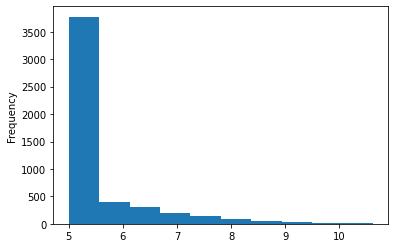

In [32]:
test_Y_df = pd.DataFrame(test_Y)
test_Y_df.stack().plot.hist()

In [40]:
print('CI score is: ', ci_score.item())
print('MSE score is: ', test(model, nn.MSELoss(reduction = 'sum'), verbose = False))

CI score is:  0.8709102869033813
MSE score is:  0.3031930622702349


In [35]:
def classify(true, preds, dataset):
  if dataset == 'kiba':
    threshold = 12.1
  else:
    threshold = 7
  
  clf_res = torch.zeros((len(preds), 1))
  clf_res[preds > threshold] = 1
  clf_res[preds <= threshold] = 0

  clf_true = torch.zeros((len(true), 1))
  clf_true[true > threshold] = 1
  clf_true[true <= threshold] = 0

  return clf_true, clf_res

In [36]:
clf_preds, clf_labels = classify(true, preds, 'davis')

clf_preds = clf_preds.cpu().numpy()
clf_labels = clf_labels.cpu().numpy()

In [37]:
def sens_spec(true, preds):
  tn, fp, fn, tp = confusion_matrix(true, preds).ravel()

  sens = (tp / (tp + fn))
  spec = (tn / (tn + fp))

  return sens, spec

In [38]:
print(classification_report(clf_labels, clf_preds))

sens, spec = sens_spec(clf_labels, clf_preds)
print('Specificiy: ', spec)
print('Sensitivity: ', sens)

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      4587
         1.0       0.67      0.65      0.66       423

    accuracy                           0.94      5010
   macro avg       0.82      0.81      0.81      5010
weighted avg       0.94      0.94      0.94      5010

Specificiy:  0.9705689993459777
Sensitivity:  0.6501182033096927
